#Multivariate	LSTM	models
### Importing data and pre processing

In [7]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [8]:
# Load the dataset
data = pd.read_csv('/content/stock_dataset (1).csv')
print("Dataset Head:\n", data.head())


Dataset Head:
   symbol                       date   close    high       low    open  \
0   GOOG  2016-06-14 00:00:00+00:00  718.27  722.47  713.1200  716.48   
1   GOOG  2016-06-15 00:00:00+00:00  718.92  722.98  717.3100  719.00   
2   GOOG  2016-06-16 00:00:00+00:00  710.36  716.65  703.2600  714.91   
3   GOOG  2016-06-17 00:00:00+00:00  691.72  708.82  688.4515  708.65   
4   GOOG  2016-06-20 00:00:00+00:00  693.71  702.48  693.4100  698.77   

    volume  adjClose  adjHigh    adjLow  adjOpen  adjVolume  divCash  \
0  1306065    718.27   722.47  713.1200   716.48    1306065      0.0   
1  1214517    718.92   722.98  717.3100   719.00    1214517      0.0   
2  1982471    710.36   716.65  703.2600   714.91    1982471      0.0   
3  3402357    691.72   708.82  688.4515   708.65    3402357      0.0   
4  2082538    693.71   702.48  693.4100   698.77    2082538      0.0   

   splitFactor  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  


In [9]:
# Handle missing values (if any)
data = data.fillna(method='ffill')

<ipython-input-9-1f261aad86e3>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [11]:
# Select relevant columns (example: Close and Volume for simplicity)
features = ['close', 'volume']
data = data[features]


In [12]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [13]:
# Create sequences for multiple input series
def create_sequences(data, sequence_length, target_index=0):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])  # Use all features
        y.append(data[i, target_index])  # Target variable
    return np.array(X), np.array(y)

In [14]:
# Hyperparameters
sequence_length = 50  # Number of time steps
target_index = 0  # Predict the 'Close' column

In [15]:

# Prepare data
X, y = create_sequences(scaled_data, sequence_length, target_index)

In [16]:
# Split into training and testing datasets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (966, 50, 2), (966,)
Testing data shape: (242, 50, 2), (242,)


# 1. Multiple Input Series Model

In [17]:
# 1. Multiple Input Series Model
def create_multiple_input_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [18]:
# Train the model
multi_input_model = create_multiple_input_lstm((X_train.shape[1], X_train.shape[2]))
history = multi_input_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0257 - val_loss: 0.0641
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.0433e-04 - val_loss: 0.0018
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.9282e-04 - val_loss: 0.0015
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 4.0488e-04 - val_loss: 0.0022
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.0341e-04 - val_loss: 0.0021
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5881e-04 - val_loss: 0.0017
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.9903e-04 - val_loss: 0.0013
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.3213e-04 - val_loss: 0.0013
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.0694e-04 - val_loss: 0.0011


In [19]:
# Evaluate the model
y_pred = multi_input_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Multiple Input Series Model Metrics - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Multiple Input Series Model Metrics - MSE: 0.0011, MAE: 0.0264, RMSE: 0.0336, R²: 0.9623


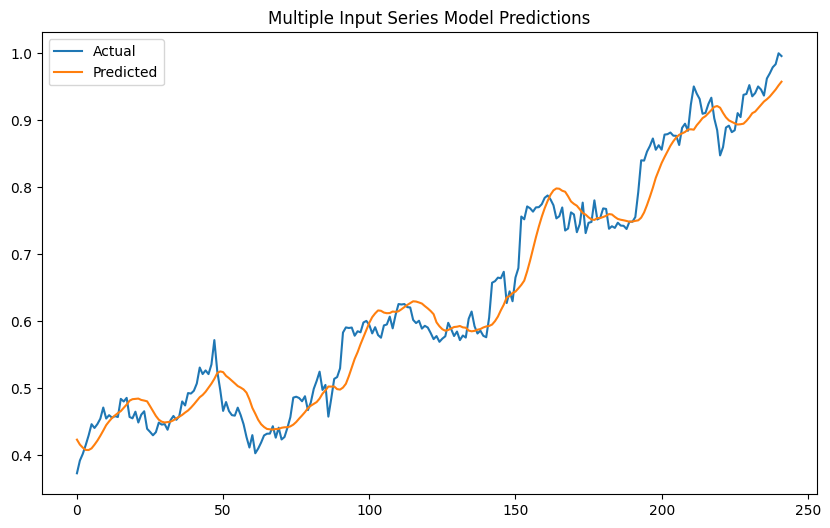

In [20]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Multiple Input Series Model Predictions")
plt.legend()
plt.show()


# 2. Multiple Parallel Series Model


In [21]:
# Create sequences for parallel series (output all features)
X_parallel, y_parallel = create_sequences(scaled_data, sequence_length, target_index=None)


In [22]:
# Split the data
X_train_p, X_test_p = X_parallel[:split], X_parallel[split:]
y_train_p, y_test_p = y_parallel[:split], y_parallel[split:]

print(f"Parallel data shape: {X_train_p.shape}, {y_train_p.shape}")


Parallel data shape: (966, 50, 2), (966, 1, 2)


In [23]:
# Define the model
def create_parallel_series_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(input_shape[-1])  # Output one value per feature
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [24]:
# Train the model
parallel_model = create_parallel_series_lstm((X_train_p.shape[1], X_train_p.shape[2]))
history_p = parallel_model.fit(X_train_p, y_train_p, epochs=10, batch_size=32, validation_data=(X_test_p, y_test_p), verbose=1)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0384 - val_loss: 0.0925
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0144 - val_loss: 0.0821
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0151 - val_loss: 0.0864
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0117 - val_loss: 0.0894
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0125 - val_loss: 0.0923
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0126 - val_loss: 0.1012
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0120 - val_loss: 0.1053
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0129 - val_loss: 0.0953
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0123 - val_loss: 0.0955
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0127 - val_loss: 0.0997


In [25]:

# Evaluate the model
y_pred_p = parallel_model.predict(X_test_p)
print("Shape of predictions:", y_pred_p.shape)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of predictions: (242, 2)


In [28]:
# Calculate metrics for one feature (example: Close)
mse_p = mean_squared_error(y_test_p[:, 0, 0], y_pred_p[:, 0]) # Added an extra index to access the values correctly
mae_p = mean_absolute_error(y_test_p[:, 0, 0], y_pred_p[:, 0]) # Added an extra index to access the values correctly
rmse_p = np.sqrt(mse_p)
r2_p = r2_score(y_test_p[:, 0, 0], y_pred_p[:, 0]) # Added an extra index to access the values correctly
print(f"Multiple Parallel Series Model Metrics (Close) - MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, RMSE: {rmse_p:.4f}, R²: {r2_p:.4f}")

Multiple Parallel Series Model Metrics (Close) - MSE: 0.1889, MAE: 0.4004, RMSE: 0.4347, R²: -5.3157


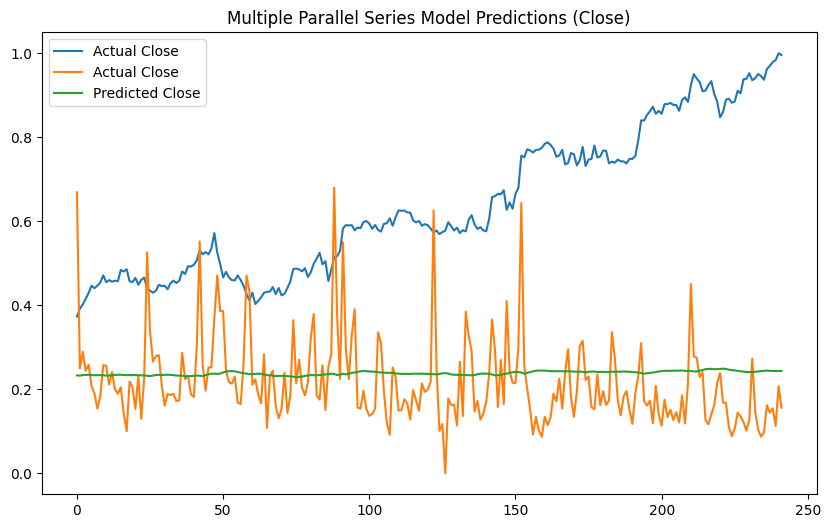

In [29]:
# Plot predictions for 'Close'
plt.figure(figsize=(10, 6))
plt.plot(y_test_p[:, 0], label='Actual Close')
plt.plot(y_pred_p[:, 0], label='Predicted Close')
plt.title("Multiple Parallel Series Model Predictions (Close)")
plt.legend()
plt.show()